
# TextToEmbedding Pipeline Demo

## This notebook demonstrates how to use the TextToEmbedding pipeline to convert text data into embeddings using the SONAR model.

### Setup
First, let's import the necessary libraries and set up logging.


In [9]:
import logging
from datasets import load_dataset
from huggingface_pipelines.pipeline_config import TextToEmbeddingPipelineConfig, EmbeddingToTextPipelineConfig, MetricPipelineConfig
from huggingface_pipelines.text import HFTextToEmbeddingPipeline, HFEmbeddingToTextPipeline
from huggingface_pipelines.metric_analyzer import MetricAnalyzerPipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset
## We'll use the AG News dataset for this demonstration.



In [10]:

dataset = load_dataset("ag_news", split="test[:100]")  # Load only 100 samples for demo
print(dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 100
})


## Configure Pipeline
### Now, let's set up the TextToEmbedding pipeline configuration.


In [11]:
config = TextToEmbeddingPipelineConfig(
    dataset_name="ag_news",
    columns=["text"]
).with_overwrites({
    "encoder_model": "text_sonar_basic_encoder",
    "source_lang": "eng_Latn",
    "output_file_name": "ag_news_results",
    "take": 1  # Process 100 samples
})


pipeline = HFTextToEmbeddingPipeline(config)
dataset = pipeline(dataset)

print(dataset[:5])




INFO:huggingface_pipelines.text:Initializing text to embedding model...
INFO:huggingface_pipelines.text:Model initialized.
INFO:huggingface_pipelines.pipeline:Starting to process dataset...
Map:   0%|          | 0/5 [00:00<?, ? examples/s]INFO:huggingface_pipelines.text:Encoding 5 texts...
INFO:huggingface_pipelines.text:Texts encoded successfully.
Map: 100%|██████████| 5/5 [00:07<00:00,  1.59s/ examples]

{'text': ["Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.", 'The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\\privately funded suborbital space flight, has officially announced the first\\launch date for its manned rocket.', 'Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.', "Prediction Unit Helps Forecast Wildfires (AP) AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning will strike

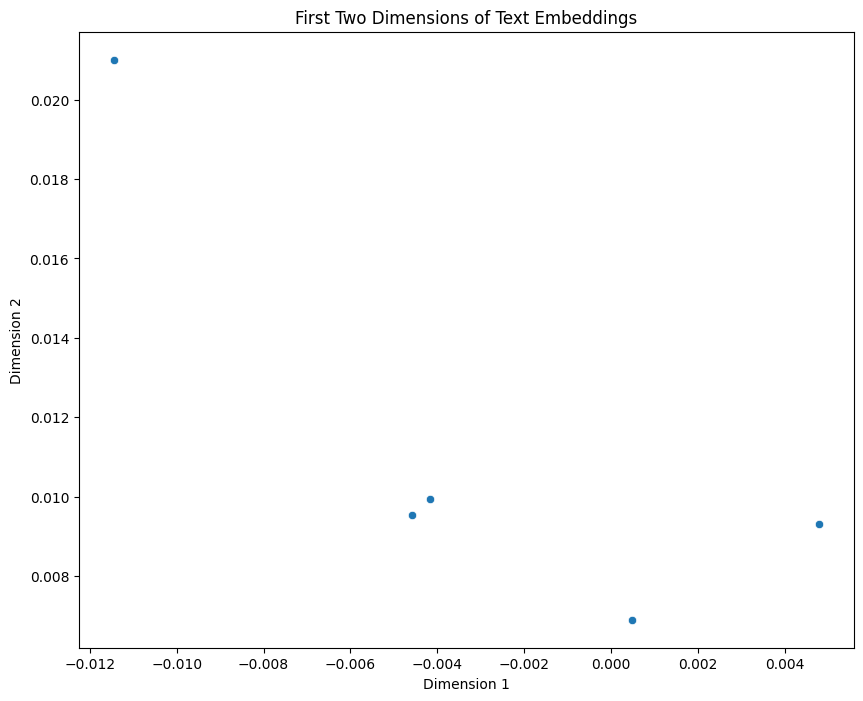

In [14]:

embeddings = dataset['text_embeddings'][:100]
plt.figure(figsize=(10, 8))
sns.scatterplot(x=[e[0] for e in embeddings], y=[e[1] for e in embeddings])
plt.title('First Two Dimensions of Text Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


# We'll use the dataset with embeddings from the previous TextToEmbedding pipeline.


In [15]:
config = EmbeddingToTextPipelineConfig(
    dataset_name="ag_news",
    columns=["text_embeddings"]
).with_overwrites({
    "decoder_model": "text_sonar_basic_decoder",
    "target_lang": "eng_Latn",
    "output_file_name": "ag_news_results",
    "take": 1
})

## Initialize and Run Pipeline

In [17]:
pipeline = HFEmbeddingToTextPipeline(config)
dataset = pipeline(dataset)


INFO:huggingface_pipelines.text:Initializing embedding to text model...


KeyboardInterrupt: 

## Display Results

In [ ]:
for original, reconstructed in zip(dataset['text'][:5], dataset['text_reconstructed'][:5]):
    print(f"Original: {original}")
    print(f"Reconstructed: {reconstructed}")
    print()

## Analyze Reconstruction Quality
### Let's compare the embeddings of original and reconstructed texts.

In [ ]:
metric_analyzer_config = MetricPipelineConfig(
    dataset_name="ag_news",
    dataset_split="test",
    columns=["text"]
).with_overwrites({
    "metric_name": "bleu",
    "low_score_threshold": 0.5,
    "output_file_name": "ag_news_results",
    "take": 1
})

pipeline = MetricAnalyzerPipeline(metric_analyzer_config)

dataset = pipeline(dataset)

plt.figure(figsize=(10, 6))
sns.histplot(processed_dataset['bleu_score'], kde=True)
plt.title('Distribution of BLEU Scores')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.axvline(x=config.low_score_threshold, color='r', linestyle='--', label='Low Score Threshold')
plt.legend()
plt.show()


low_scoring = processed_dataset.filter(lambda x: x['bleu_score'] < config.low_score_threshold)
print(f"Number of low-scoring samples: {len(low_scoring)}")

for sample in low_scoring[:5]:
    print(f"Original: {sample['text']}")
    print(f"Reconstructed: {sample['text_reconstructed']}")
    print(f"BLEU Score: {sample['bleu_score']}")
    print()
